Code from OpenAI Cookbook
https://cookbook.openai.com/examples/chat_finetuning_data_prep

In [18]:
import json
import os
import tiktoken # for token counting
import numpy as np
from collections import defaultdict
import openai
import pandas as pd
import matplotlib.pyplot as plt
import requests
import base64
import logging
import itertools
import time
import random
from tenacity import retry, stop_after_attempt, wait_random_exponential
import seaborn as sns
import matplotlib.pyplot as plt

import cookbook_function as cbf

In [19]:
# Authenticate with OpenAI API
TestKey3 = "sk-proj-GL73kbRwhRpgN3EmXz1YT3BlbkFJEMJhTsinxQDel42BZdNz"
headers = {
    "Authorization": f"Bearer {TestKey3}"
}
client = openai.OpenAI(api_key=TestKey3)

Validate Data Format

In [3]:
# load jsonl file
data_paths = ["data/finetuning_data/training_data.jsonl", 
              "data/finetuning_data/testing_data.jsonl", 
              "data/finetuning_data/validation_data.jsonl"
              ]

# Load the dataset
datasets=[]
for data_path in data_paths:
    cbf.validate_jsonl(data_path)
    with open(data_path, 'r', encoding='utf-8') as f:
        dataset = [json.loads(line) for line in f]
        print(type(dataset))
    datasets.append(dataset)
    # Initial dataset stats
    print("{} :".format(data_path))
    print("Num examples:", len(dataset))
    print("First example:")
    for message in dataset[0]["messages"]:
        print(message)
    

<class 'list'>
data/finetuning_data/training_data.jsonl :
Num examples: 1114
First example:
{'role': 'system', 'content': 'Imagine you are a member of the European\n         Parliament and based on your years of experience, you are an expert in \n         predicting how the different party groups will vote on a given law. Given\n         a legislative proposal, predict the percentage of votes in favour \n         from each party group. Assess the political \n         direction, wording, framing, and topic relevance of the law to inform your \n         predictions. Determine the type of majority (General, Left, Right, Consensus) \n         likely to support the legislation based on party alignments. Reply with numerical\n         values only.'}
{'role': 'user', 'content': "Conclusion of the EU-China Civil Aviation Safety Agreement: PURPOSE: to conclude an agreement on civil aviation safety between the European Union and the Government of the People's Republic of China. PROPOSED ACT: Cou

In [4]:
# check for format errors
for dataset in datasets:
    cbf.check_format(dataset)

No errors found
No errors found
No errors found


In [5]:
# check for missing data, distribution of messages in each conversation,
# distribution of tokens per conversation, print token limit warnings

# Warnings and tokens counts
n_missing_system = 0
n_missing_user = 0
n_messages = []
convo_lens = []
assistant_message_lens = []

for dataset in datasets:
    for ex in dataset:
        messages = ex["messages"]
        if not any(message["role"] == "system" for message in messages):
            n_missing_system += 1
        if not any(message["role"] == "user" for message in messages):
            n_missing_user += 1
        n_messages.append(len(messages))
        convo_lens.append(cbf.num_tokens_from_messages(messages))
        assistant_message_lens.append(cbf.num_assistant_tokens_from_messages(messages))
        
    print("Num examples missing system message:", n_missing_system)
    print("Num examples missing user message:", n_missing_user)
    cbf.print_distribution(n_messages, "num_messages_per_example")
    #print_distribution(convo_lens, "num_total_tokens_per_example")
    cbf.print_distribution(assistant_message_lens, "num_assistant_tokens_per_example")
    n_too_long = sum(l > 4096 for l in convo_lens)
    print(f"\n{n_too_long} examples may be over the 4096 token limit, they will be truncated during fine-tuning")

Num examples missing system message: 0
Num examples missing user message: 0

#### Distribution of num_messages_per_example:
min / max: 3, 3
mean / median: 3.0, 3.0
p5 / p95: 3.0, 3.0

#### Distribution of num_assistant_tokens_per_example:
min / max: 93, 94
mean / median: 93.89587073608618, 94.0
p5 / p95: 93.0, 94.0

0 examples may be over the 4096 token limit, they will be truncated during fine-tuning
Num examples missing system message: 0
Num examples missing user message: 0

#### Distribution of num_messages_per_example:
min / max: 3, 3
mean / median: 3.0, 3.0
p5 / p95: 3.0, 3.0

#### Distribution of num_assistant_tokens_per_example:
min / max: 93, 94
mean / median: 93.89393939393939, 94.0
p5 / p95: 93.0, 94.0

0 examples may be over the 4096 token limit, they will be truncated during fine-tuning
Num examples missing system message: 0
Num examples missing user message: 0

#### Distribution of num_messages_per_example:
min / max: 3, 3
mean / median: 3.0, 3.0
p5 / p95: 3.0, 3.0

#### D

Estimate costs

In [6]:
# Pricing and default n_epochs estimate
MAX_TOKENS_PER_EXAMPLE = 4096

TARGET_EPOCHS = 3
MIN_TARGET_EXAMPLES = 100
MAX_TARGET_EXAMPLES = 25000
MIN_DEFAULT_EPOCHS = 1
MAX_DEFAULT_EPOCHS = 25

n_epochs = TARGET_EPOCHS
n_train_examples = len(datasets[0]) # only training data
if n_train_examples * TARGET_EPOCHS < MIN_TARGET_EXAMPLES:
    n_epochs = min(MAX_DEFAULT_EPOCHS, MIN_TARGET_EXAMPLES // n_train_examples)
elif n_train_examples * TARGET_EPOCHS > MAX_TARGET_EXAMPLES:
    n_epochs = max(MIN_DEFAULT_EPOCHS, MAX_TARGET_EXAMPLES // n_train_examples)

n_billing_tokens_in_dataset = sum(min(MAX_TOKENS_PER_EXAMPLE, length) for length in convo_lens)
print(f"Dataset has ~{n_billing_tokens_in_dataset} tokens that will be charged for during training")
print(f"By default, you'll train for {n_epochs} epochs on this dataset")
print(f"By default, you'll be charged for ~{n_epochs * n_billing_tokens_in_dataset} tokens")

Dataset has ~1408040 tokens that will be charged for during training
By default, you'll train for 3 epochs on this dataset
By default, you'll be charged for ~4224120 tokens


Upload validated files to OpenAI API

In [7]:
# upload validated data file to OpenAI API

train_upload = client.files.create(
  file=open("data/finetuning_data/small_training_data.jsonl", "rb"),
  purpose="fine-tune"
)
val_upload = client.files.create(
  file=open("data/finetuning_data/small_validation_data.jsonl", "rb"),
  purpose="fine-tune"
)

print("Uploaded training file id:", train_upload.id)
print("Uploaded validation file id:", val_upload.id)

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/files "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/files "HTTP/1.1 200 OK"


Uploaded training file id: file-MKIAphEdtV4waMhaKCeXH9k0
Uploaded validation file id: file-1V6XLEkR2GUmXp1jRk9pvHBg


Create Fine-Tuning Job via OpenAI Software Development Kit

In [11]:
learning_rate_multiplier = [2, 5, 10]
n_epochs = [2, 3, 5]
batch_size = [1]

pause_time = 10  # Time to wait between batches in seconds
max_retries = 5  # Maximum retries for each request

# Rate limit settings
# code snippets from https://github.com/openai/openai-cookbook/blob/main/examples/How_to_handle_rate_limits.ipynb
rate_limit = 3  # Number of requests per minute
request_interval = 60 / rate_limit  # Interval in seconds

# Generate all combinations of hyperparameters
all_combinations = list(itertools.product(learning_rate_multiplier, n_epochs, batch_size))
print(len(all_combinations), "combinations in total")

def monitor_jobs(job_id):
    event_ls = [client.fine_tuning.jobs.list_events(
            fine_tuning_job_id=job_id,
            limit=10
                )
            ]
    return event_ls

def get_result_files(job_id):
    """
    Takes as input the job_id of a finished fine-tuning job and
    returns the name, not the content, of the result files.
    The result files' content can be accessed by querying the API
    with the function get_ft_results.
    """
    result_files = client.fine_tuning.jobs.retrieve(job_id).result_files
    return result_files

# Function to process a batch of jobs
def process_jobs(combinations, train_upload, val_upload=None):
    """
    Takes as input a list of hyperparameter combinations and the file ids
    of the training and validation files. Processes each combination by 
    creating a fine-tuning job with the specified hyperparameters. Respects
    the rate limit by waiting between requests. Returns a list of results
    which include the job_id, hyperparameters, status, events, and result file
    names.  
    """
    results = []
    last_request_time = time.time() - request_interval  # Initialize to allow immediate first request
    # Loop through each combination of hyperparameters while using batches
    for lr, epoch, batch in combinations:
        # Retry loop to handle rate limiting
        for attempt in range(max_retries):
            # Setting time to wait between requests
            print(f"Processing hyperparameters (lr={lr}, epoch={epoch}, batch={batch})")
            current_time = time.time()
            elapsed_time = current_time - last_request_time
                
            if elapsed_time < request_interval:
                sleep_time = request_interval - elapsed_time
                print(f"Rate limiting: Sleeping for {sleep_time:.2f} seconds")
                time.sleep(sleep_time)
            try:
                response = client.fine_tuning.jobs.create(
                    training_file=train_upload.id,  # file id returned after upload to API
                    validation_file=val_upload.id,  # file id returned after upload to API
                    model="gpt-3.5-turbo",
                    suffix="small",
                    seed=124,
                    hyperparameters={
                        "n_epochs": epoch,
                        "batch_size": batch,
                        "learning_rate_multiplier": lr
                    }
                )
                job_id = response.id
                print(f"Job created with ID {job_id}")
                results.append({
                    "job_id": job_id,
                    "learning_rate_multiplier": lr,
                    "n_epochs": epoch,
                    "batch_size": batch,
                    "status": response.status,
                    "events": monitor_jobs(job_id),
                    "result_file_name": get_result_files(job_id)
                })
                last_request_time = time.time()
                break  # Break out of the retry loop if the request is successful
            except Exception as e:
                if "429" in str(e):  # Check if the error is a rate limiting error
                    wait_time = (2 ** attempt) + random.uniform(0, 1)
                    print(f"Rate limit exceeded. Retrying in {wait_time:.2f} seconds...")
                    time.sleep(wait_time)
                else:
                    print(f"An error occurred: {e}")
                    break
    return results

# Process jobs in batches
all_results = process_jobs(all_combinations, train_upload, val_upload)
print("All batches processed.")


9 combinations in total
Processing hyperparameters (lr=2, epoch=2, batch=1)


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/fine_tuning/jobs "HTTP/1.1 200 OK"


Job created with ID ftjob-HeYo5c3ukkqbi5c9NY6BrC7w


INFO:httpx:HTTP Request: GET https://api.openai.com/v1/fine_tuning/jobs/ftjob-HeYo5c3ukkqbi5c9NY6BrC7w/events?limit=10 "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.openai.com/v1/fine_tuning/jobs/ftjob-HeYo5c3ukkqbi5c9NY6BrC7w "HTTP/1.1 200 OK"


Processing hyperparameters (lr=2, epoch=3, batch=1)
Rate limiting: Sleeping for 20.00 seconds


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/fine_tuning/jobs "HTTP/1.1 200 OK"


Job created with ID ftjob-KR8Aeu4gOG0nGHR4O0UwBGYg


INFO:httpx:HTTP Request: GET https://api.openai.com/v1/fine_tuning/jobs/ftjob-KR8Aeu4gOG0nGHR4O0UwBGYg/events?limit=10 "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.openai.com/v1/fine_tuning/jobs/ftjob-KR8Aeu4gOG0nGHR4O0UwBGYg "HTTP/1.1 200 OK"


Processing hyperparameters (lr=2, epoch=5, batch=1)
Rate limiting: Sleeping for 20.00 seconds


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/fine_tuning/jobs "HTTP/1.1 200 OK"


Job created with ID ftjob-3sFnb5d6ZN0mg2L8NPOig7a8


INFO:httpx:HTTP Request: GET https://api.openai.com/v1/fine_tuning/jobs/ftjob-3sFnb5d6ZN0mg2L8NPOig7a8/events?limit=10 "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.openai.com/v1/fine_tuning/jobs/ftjob-3sFnb5d6ZN0mg2L8NPOig7a8 "HTTP/1.1 200 OK"


Processing hyperparameters (lr=5, epoch=2, batch=1)
Rate limiting: Sleeping for 20.00 seconds


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/fine_tuning/jobs "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /fine_tuning/jobs in 0.845491 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/fine_tuning/jobs "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /fine_tuning/jobs in 1.838708 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/fine_tuning/jobs "HTTP/1.1 429 Too Many Requests"


Rate limit exceeded. Retrying in 1.10 seconds...


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/fine_tuning/jobs "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /fine_tuning/jobs in 0.974021 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/fine_tuning/jobs "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /fine_tuning/jobs in 1.984668 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/fine_tuning/jobs "HTTP/1.1 429 Too Many Requests"


Rate limit exceeded. Retrying in 2.96 seconds...


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/fine_tuning/jobs "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /fine_tuning/jobs in 0.880656 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/fine_tuning/jobs "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /fine_tuning/jobs in 1.529924 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/fine_tuning/jobs "HTTP/1.1 429 Too Many Requests"


Rate limit exceeded. Retrying in 4.93 seconds...


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/fine_tuning/jobs "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /fine_tuning/jobs in 0.897569 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/fine_tuning/jobs "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /fine_tuning/jobs in 1.739534 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/fine_tuning/jobs "HTTP/1.1 429 Too Many Requests"


Rate limit exceeded. Retrying in 8.86 seconds...


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/fine_tuning/jobs "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /fine_tuning/jobs in 0.972467 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/fine_tuning/jobs "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /fine_tuning/jobs in 1.578454 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/fine_tuning/jobs "HTTP/1.1 429 Too Many Requests"


Rate limit exceeded. Retrying in 16.98 seconds...
Processing hyperparameters (lr=5, epoch=3, batch=1)


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/fine_tuning/jobs "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /fine_tuning/jobs in 0.931674 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/fine_tuning/jobs "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /fine_tuning/jobs in 1.628564 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/fine_tuning/jobs "HTTP/1.1 429 Too Many Requests"


Rate limit exceeded. Retrying in 1.71 seconds...


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/fine_tuning/jobs "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /fine_tuning/jobs in 0.925301 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/fine_tuning/jobs "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /fine_tuning/jobs in 1.547003 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/fine_tuning/jobs "HTTP/1.1 429 Too Many Requests"


Rate limit exceeded. Retrying in 2.92 seconds...


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/fine_tuning/jobs "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /fine_tuning/jobs in 0.936135 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/fine_tuning/jobs "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /fine_tuning/jobs in 1.997715 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/fine_tuning/jobs "HTTP/1.1 429 Too Many Requests"


Rate limit exceeded. Retrying in 4.78 seconds...


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/fine_tuning/jobs "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /fine_tuning/jobs in 0.919944 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/fine_tuning/jobs "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /fine_tuning/jobs in 1.676578 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/fine_tuning/jobs "HTTP/1.1 429 Too Many Requests"


Rate limit exceeded. Retrying in 8.10 seconds...


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/fine_tuning/jobs "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /fine_tuning/jobs in 0.858842 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/fine_tuning/jobs "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /fine_tuning/jobs in 1.859640 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/fine_tuning/jobs "HTTP/1.1 429 Too Many Requests"


Rate limit exceeded. Retrying in 16.89 seconds...
Processed batch 1
Pausing for 10 seconds between batches...
Processing hyperparameters (lr=5, epoch=5, batch=1)


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/fine_tuning/jobs "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /fine_tuning/jobs in 0.920270 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/fine_tuning/jobs "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /fine_tuning/jobs in 1.927983 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/fine_tuning/jobs "HTTP/1.1 200 OK"


Job created with ID ftjob-onRZWyNygXJjB9qk8UKt0bOu


INFO:httpx:HTTP Request: GET https://api.openai.com/v1/fine_tuning/jobs/ftjob-onRZWyNygXJjB9qk8UKt0bOu/events?limit=10 "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.openai.com/v1/fine_tuning/jobs/ftjob-onRZWyNygXJjB9qk8UKt0bOu "HTTP/1.1 200 OK"


Processing hyperparameters (lr=100, epoch=2, batch=1)
Rate limiting: Sleeping for 20.00 seconds


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/fine_tuning/jobs "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /fine_tuning/jobs in 0.974842 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/fine_tuning/jobs "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /fine_tuning/jobs in 1.767160 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/fine_tuning/jobs "HTTP/1.1 429 Too Many Requests"


Rate limit exceeded. Retrying in 1.82 seconds...


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/fine_tuning/jobs "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /fine_tuning/jobs in 0.795143 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/fine_tuning/jobs "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /fine_tuning/jobs in 1.675049 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/fine_tuning/jobs "HTTP/1.1 429 Too Many Requests"


Rate limit exceeded. Retrying in 2.99 seconds...


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/fine_tuning/jobs "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /fine_tuning/jobs in 0.813780 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/fine_tuning/jobs "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /fine_tuning/jobs in 1.656207 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/fine_tuning/jobs "HTTP/1.1 429 Too Many Requests"


Rate limit exceeded. Retrying in 4.74 seconds...


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/fine_tuning/jobs "HTTP/1.1 200 OK"


Job created with ID ftjob-Oipg075xU2czQBFUYYSmj4iW


INFO:httpx:HTTP Request: GET https://api.openai.com/v1/fine_tuning/jobs/ftjob-Oipg075xU2czQBFUYYSmj4iW/events?limit=10 "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.openai.com/v1/fine_tuning/jobs/ftjob-Oipg075xU2czQBFUYYSmj4iW "HTTP/1.1 200 OK"


Processing hyperparameters (lr=100, epoch=3, batch=1)
Rate limiting: Sleeping for 20.00 seconds


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/fine_tuning/jobs "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /fine_tuning/jobs in 0.802443 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/fine_tuning/jobs "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /fine_tuning/jobs in 1.566473 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/fine_tuning/jobs "HTTP/1.1 429 Too Many Requests"


Rate limit exceeded. Retrying in 1.40 seconds...


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/fine_tuning/jobs "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /fine_tuning/jobs in 0.917250 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/fine_tuning/jobs "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /fine_tuning/jobs in 1.876985 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/fine_tuning/jobs "HTTP/1.1 429 Too Many Requests"


Rate limit exceeded. Retrying in 2.89 seconds...


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/fine_tuning/jobs "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /fine_tuning/jobs in 0.871441 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/fine_tuning/jobs "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /fine_tuning/jobs in 1.987324 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/fine_tuning/jobs "HTTP/1.1 429 Too Many Requests"


Rate limit exceeded. Retrying in 4.87 seconds...


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/fine_tuning/jobs "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /fine_tuning/jobs in 0.833501 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/fine_tuning/jobs "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /fine_tuning/jobs in 1.824940 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/fine_tuning/jobs "HTTP/1.1 429 Too Many Requests"


Rate limit exceeded. Retrying in 8.76 seconds...


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/fine_tuning/jobs "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /fine_tuning/jobs in 0.912556 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/fine_tuning/jobs "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /fine_tuning/jobs in 1.951150 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/fine_tuning/jobs "HTTP/1.1 429 Too Many Requests"


Rate limit exceeded. Retrying in 16.01 seconds...
Processing hyperparameters (lr=100, epoch=5, batch=1)


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/fine_tuning/jobs "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /fine_tuning/jobs in 0.945611 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/fine_tuning/jobs "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /fine_tuning/jobs in 1.516278 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/fine_tuning/jobs "HTTP/1.1 429 Too Many Requests"


Rate limit exceeded. Retrying in 1.49 seconds...


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/fine_tuning/jobs "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /fine_tuning/jobs in 0.827622 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/fine_tuning/jobs "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /fine_tuning/jobs in 1.715870 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/fine_tuning/jobs "HTTP/1.1 429 Too Many Requests"


Rate limit exceeded. Retrying in 2.91 seconds...


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/fine_tuning/jobs "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /fine_tuning/jobs in 0.950458 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/fine_tuning/jobs "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /fine_tuning/jobs in 1.871564 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/fine_tuning/jobs "HTTP/1.1 429 Too Many Requests"


Rate limit exceeded. Retrying in 4.25 seconds...


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/fine_tuning/jobs "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /fine_tuning/jobs in 0.929954 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/fine_tuning/jobs "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /fine_tuning/jobs in 1.668265 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/fine_tuning/jobs "HTTP/1.1 429 Too Many Requests"


Rate limit exceeded. Retrying in 8.15 seconds...


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/fine_tuning/jobs "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /fine_tuning/jobs in 0.901302 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/fine_tuning/jobs "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /fine_tuning/jobs in 1.542679 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/fine_tuning/jobs "HTTP/1.1 200 OK"


Job created with ID ftjob-wVYVITVHX9kOdGlua3PEvFwG


INFO:httpx:HTTP Request: GET https://api.openai.com/v1/fine_tuning/jobs/ftjob-wVYVITVHX9kOdGlua3PEvFwG/events?limit=10 "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.openai.com/v1/fine_tuning/jobs/ftjob-wVYVITVHX9kOdGlua3PEvFwG "HTTP/1.1 200 OK"


Processed batch 2
All batches processed.


Getting Metrics / Evaluation

In [16]:
job_id = (all_results[0]["job_id"])
one_result = get_result_files("ftjob-KR8Aeu4gOG0nGHR4O0UwBGYg")
print(one_result)

[{'job_id': 'ftjob-HeYo5c3ukkqbi5c9NY6BrC7w', 'learning_rate_multiplier': 2, 'n_epochs': 2, 'batch_size': 1, 'status': 'validating_files', 'events': [SyncCursorPage[FineTuningJobEvent](data=[FineTuningJobEvent(id='ftevent-LVhP7Elb0ecyB5hpjnUJueIu', created_at=1721831407, level='info', message='Validating training file: file-MKIAphEdtV4waMhaKCeXH9k0 and validation file: file-1V6XLEkR2GUmXp1jRk9pvHBg', object='fine_tuning.job.event', data={}, type='message'), FineTuningJobEvent(id='ftevent-vFj4vX2Py2x5ho2bDSDKGH5Y', created_at=1721831407, level='info', message='Created fine-tuning job: ftjob-HeYo5c3ukkqbi5c9NY6BrC7w', object='fine_tuning.job.event', data={}, type='message')], object='list', has_more=False)], 'result_files': []}, {'job_id': 'ftjob-KR8Aeu4gOG0nGHR4O0UwBGYg', 'learning_rate_multiplier': 2, 'n_epochs': 3, 'batch_size': 1, 'status': 'validating_files', 'events': [SyncCursorPage[FineTuningJobEvent](data=[FineTuningJobEvent(id='ftevent-XdgLMesISo2OLjEGGNZjD2kW', created_at=1721

INFO:httpx:HTTP Request: GET https://api.openai.com/v1/fine_tuning/jobs/ftjob-KR8Aeu4gOG0nGHR4O0UwBGYg "HTTP/1.1 200 OK"


['file-CNFRk558UUo8onYhGLLjTFym']


In [17]:
# # create empty csv files with columnn names train_loss, val_loss, train_ppl, val_ppl
# with open("decoded_content.csv", "w") as f:	
#     f.write("train_loss, train_accuracy, valid_loss, valid_mean_token_accuracy\n")



# concatenate all results files to one dataframe
for i in range(len(all_results)):

    # get job_id
    job_id = all_results[i]["job_id"]
    # get result_files
    result_file_name = all_results[i]["result_file_name"]
    # get hyperparameters
    lr_multiplier = all_results[i]["learning_rate_multiplier"]
    n_epochs = all_results[i]["n_epochs"]
    # get metrics_df
    metrics_df = pd.read_csv(cbf.get_ft_results(result_file_name))
    # add columns to metrics_df
    metrics_df["job_id"] = job_id
    metrics_df["learning_rate_multiplier"] = lr_multiplier
    metrics_df["n_epochs"] = n_epochs
    metrics_df["result_file_name"] = result_file_name
    # add metrics_df to an overall df
    if i == 0:
        all_metrics_df = metrics_df
    else:
        all_metrics_df = pd.concat([all_metrics_df, metrics_df], axis=0)
    #checkpoints_df = cbf.get_checkpoint_results(job_id)
    # add checkpoints_df to a overall df
    #if i == 0:
    #    all_checkpoints_df = checkpoints_df
    #else:
    #    all_checkpoints_df = pd.concat([all_checkpoints_df, checkpoints_df], axis=0)
    
display(all_metrics_df.head())
#display(all_checkpoints_df.head())

KeyError: 'result_file_name'

In [10]:
# # plot the training loss and validation loss as lines in one plot
# # print two plots next to eachtother
# fig, ax = plt.subplots(1, 2, figsize=(12, 4))
# ax[0].plot(all_metrics_df["train_loss"], label="Training Loss")
# ax[0].plot(all_metrics_df["valid_loss"], label="Validation Loss")
# ax[0].set_xlabel("Step")
# ax[0].set_ylabel("Loss")
# ax[0].legend()

# ax[1].plot(all_metrics_df["train_accuracy"], label="Training Accuracy")
# ax[1].plot(all_metrics_df["valid_mean_token_accuracy"], label="Validation Mean Token Accuracy")
# ax[1].set_xlabel("Step")
# ax[1].legend()

# plt.show()

In [72]:
syn_data = {
    "Step": np.tile(np.arange(1, 11), 4),  # 10 steps for each combination
    "train_loss": np.random.rand(40) * 0.1 + 0.1,  # Random training loss values
    "valid_loss": np.random.rand(40) * 0.1 + 0.2,  # Random validation loss values
    "train_accuracy": np.random.rand(40) * 0.1 + 0.8,  # Random training accuracy values
    "valid_mean_token_accuracy": np.random.rand(40) * 0.1 + 0.75,  # Random validation accuracy values
    "job_id": np.repeat(["job_001", "job_002", "job_003", "job_004"], 10),
    "learning_rate_multiplier": np.repeat([0.5, 2, 5, 10], 10),
    "n_epochs": np.repeat([2, 3, 5, 2], 10),
    "batch_size": np.repeat([1, 1, 1, 1], 10)
}

# Create DataFrame
syn_all_metrics_df = pd.DataFrame(syn_data)
display(syn_all_metrics_df.head())

,Step,train_loss,valid_loss,train_accuracy,valid_mean_token_accuracy,job_id,learning_rate_multiplier,n_epochs,batch_size
0,1,0.145883,0.243663,0.843527,0.762868,job_001,0.5,2,1
1,2,0.192179,0.267960,0.817795,0.784336,job_001,0.5,2,1
2,3,0.110707,0.276336,0.880620,0.816779,job_001,0.5,2,1
3,4,0.177980,0.211931,0.843401,0.771227,job_001,0.5,2,1
4,5,0.199798,0.213576,0.844651,0.787332,job_001,0.5,2,1


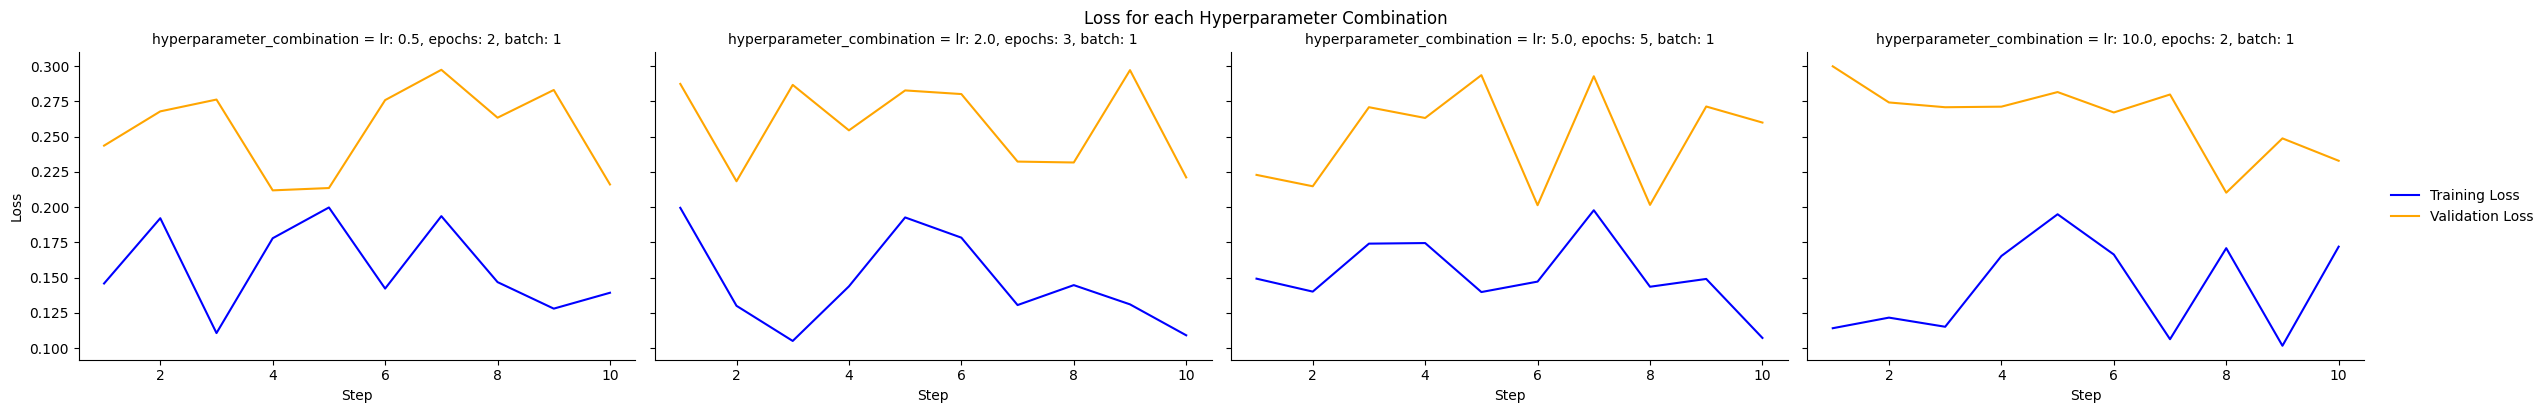

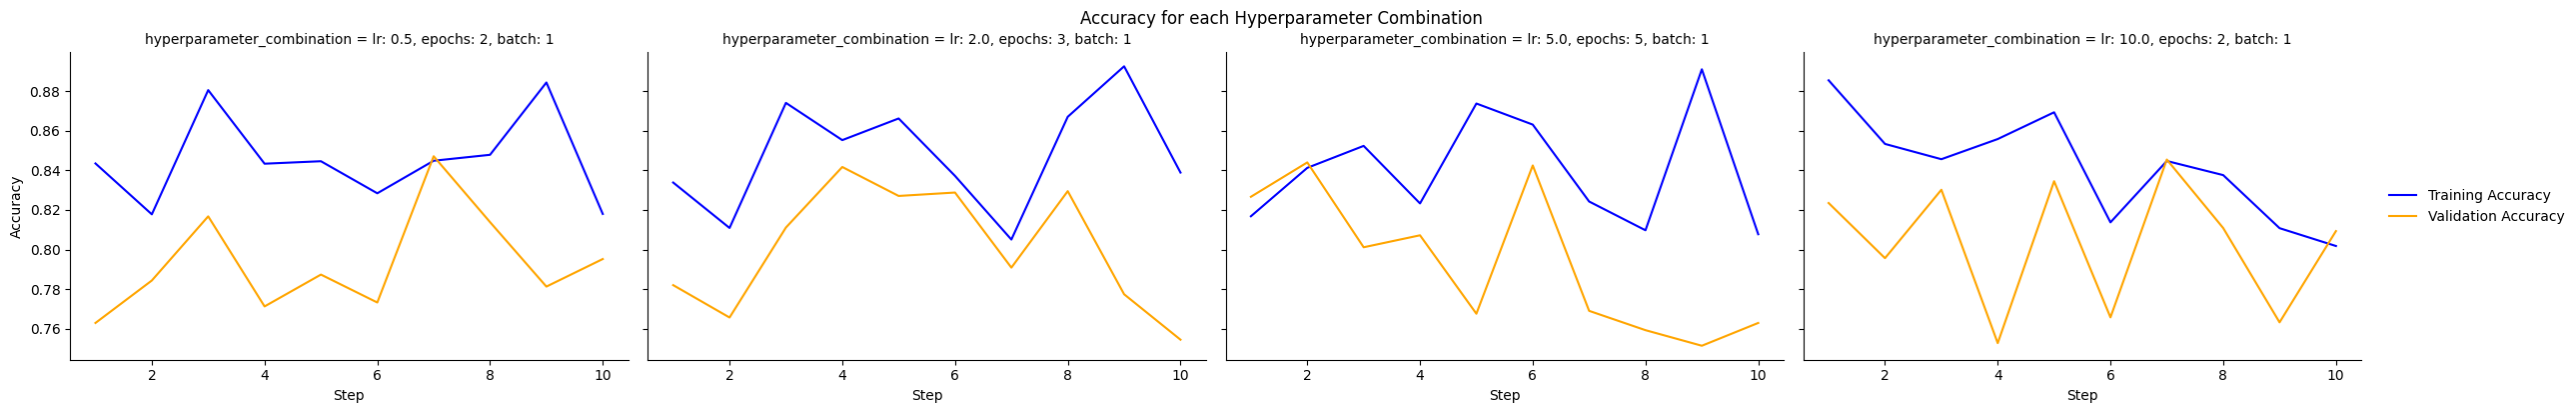

In [77]:
# Ensure the dataframe has hyperparameter columns as strings for easier plotting
all_metrics_df["learning_rate_multiplier"] = all_metrics_df["learning_rate_multiplier"].astype(str)
all_metrics_df["n_epochs"] = all_metrics_df["n_epochs"].astype(str)
all_metrics_df["batch_size"] = all_metrics_df["batch_size"].astype(str)

# Create a column to represent each hyperparameter combination
all_metrics_df["hyperparameter_combination"] = (
    "lr: " + all_metrics_df["learning_rate_multiplier"] +
    ", epochs: " + all_metrics_df["n_epochs"] +
    ", batch: " + all_metrics_df["batch_size"]
)

# Plot the losses
g = sns.FacetGrid(all_metrics_df, col="hyperparameter_combination", col_wrap=4, height=4, aspect=1.5)
g.map(plt.plot, "Step", "train_loss", label="Training Loss", color="blue")
g.map(plt.plot, "Step", "valid_loss", label="Validation Loss", color="orange")
g.add_legend()
for ax in g.axes.flat:
    ax.set_ylabel("Loss")

g.figure.suptitle('Loss for each Hyperparameter Combination', y=1.02)
plt.show()

# Plot the accuracies
g = sns.FacetGrid(all_metrics_df, col="hyperparameter_combination", col_wrap=4, height=4, aspect=1.5)
g.map(plt.plot, "Step", "train_accuracy", label="Training Accuracy",color="blue")
g.map(plt.plot, "Step", "valid_mean_token_accuracy", label="Validation Accuracy", color="orange")
g.add_legend()
for ax in g.axes.flat:
    ax.set_ylabel("Accuracy")

g.figure.suptitle('Accuracy for each Hyperparameter Combination', y=1.02)
plt.show()


In [ ]:
# List the checkpoints of the model
# and save output in a json
# with the following curl command
# curl https://api.openai.com/v1/fine_tuning/jobs/{fine_tune_job_id}/checkpoints \ -H "Authorization: Bearer {API_key}" -o checkpoint_output.json

Cancel or track a fine-tune job or delete a model

In [ ]:
# List 10 fine-tuning jobs
client.fine_tuning.jobs.list(limit=10)

# Retrieve the state of a fine-tune
client.fine_tuning.jobs.retrieve("ftjob-abc123")

# Cancel a job
client.fine_tuning.jobs.cancel("ftjob-abc123")

# List up to 10 events from a fine-tuning job
client.fine_tuning.jobs.list_events(fine_tuning_job_id="ftjob-abc123", limit=10)

# Delete a fine-tuned model (must be an owner of the org the model was created in)
client.models.delete("ft:gpt-3.5-turbo:acemeco:suffix:abc123")

Using fine-tuned model via Playground or via code

In [185]:
# save json small test set in a list of messages
test_messages = []
with open("data/finetuning_data/small_testing_data.jsonl", "r") as f:
    for line in f:
        test_messages.append(json.loads(line))

# make a request to the new model
completion = client.chat.completions.create(
  model="ft:gpt-3.5-turbo-0125:lse:small:9n7qIWZT",
  messages=test_messages,
  headers={'Authorization': f'Bearer {os.environ['TestKey3']}'}
)
print(completion.choices[0].message)

TypeError: Completions.create() got an unexpected keyword argument 'headers'

ChatCompletionMessage(content="Based on the information provided, as an expert predicting European Parliament voting patterns, here are the predicted percentages of votes in favour from each party group in the European Parliament for the proposed act on the extension of the EC-Mauritania Fisheries Partnership Agreement:\n\n1. European People's Party (EPP): 70% in favour\n
 - The EPP group tends to support agreements that promote economic opportunities, such as fisheries partnerships, as they align with principles of international cooperation and economic growth.\n\n2. Socialists and Democrats (S&D): 60% in favour\n 
 - The S&D group is likely to support agreements that focus on sustainability and cooperation, as indicated by the mention of promoting sustainable fisheries policies and sound exploitation of resources in the legislative proposal.\n\n3. Renew Europe (RE): 80% in favour\n 
 - The RE group generally supports agreements that facilitate trade and partnerships with other regions or countries, which is in line with the extension of fishing opportunities outlined in the proposal.\n\n4. Greens/European Free Alliance (Greens/EFA): 50% in favour\n 
 - The Greens/EFA group may have concerns about the environmental impact of fisheries agreements, but their support could be influenced by the emphasis on sustainable fisheries in the proposal.\n\n5. European Conservatives and Reformists (ECR): 75% in favour\n 
 - The ECR group is likely to support agreements that promote economic benefits and opportunities for European businesses, such as access to fishing waters in Mauritania.\n\n6. Identity and Democracy (ID): 40% in favour\n
  - The ID group may have reservations about international agreements that involve financial contributions, but their support could be influenced by economic interests.\n\n
Based on these predictions, a General majority (requiring a simple majority of votes cast) is likely to support the legislation due to its relevance to economic cooperation, sustainability, and promoting fisheries opportunities. The wording and framing of the law emphasize collaboration for sustainable fisheries policies, which can appeal to a broad spectrum of political ideologies within the European Parliament.", role='assistant', function_call=None, tool_calls=None)

In [41]:
# Convert list ouput back to a dataframe

response_ls = ['ECR%:0.839, EPP%:0.898, EFD/IDG%:0.562, Greens/EFA%:0.932, NI%:0.294, REG%:0.892, S&D%:0.89, The Left%:0.731, General Majority:1, Left Majority:0, Right Majority:0, Consensus:0', 'ECR%:0.563, EPP%:0.784, EFD/IDG%:0.269, Greens/EFA%:0.815, NI%:0.167, REG%:0.759, S&D%:0.803, The Left%:0.688, General Majority:0, Left Majority:0, Right Majority:0, Consensus:0', 'ECR%:0.59, EPP%:0.802, EFD/IDG%:0.188, Greens/EFA%:0.875, NI%:0.154, REG%:0.844, S&D%:0.815, The Left%:0.62, General Majority:1, Left Majority:0, Right Majority:0, Consensus:0', 'ECR%:0.636, EPP%:0.787, EFD/IDG%:0.295, Greens/EFA%:0.852, NI%:0.273, REG%:0.795, S&D%:0.813, The Left%:0.568, General Majority:1, Left Majority:0, Right Majority:0, Consensus:0', 'ECR%:0.846, EPP%:0.898, EFD/IDG%:0.423, Greens/EFA%:0.892, NI%:0.308, REG%:0.844, S&D%:0.885, The Left%:0.731, General Majority:1, Left Majority:0, Right Majority:0, Consensus:0', 'ECR%:0.828, EPP%:0.898, EFD/IDG%:0.303, Greens/EFA%:0.08, NI%:0.156, REG%:0.83, S&D%:0.772, The Left%:0.06, General Majority:0, Left Maj875, NI%:0.154, REG%:0.844, S&D%:0.815, The Left%:0.62, General Majority:1, Left Majority:0, Right Majority:0, Consensus:0', 'ECR%:0.636, EPP%:0.787, EFD/IDG%:0.295, Greens/EFA%:0.852, NI%:0.273, REG%:0.795, S&D%:0.813, The Left%:0.568, General Majority:1, Left Majority:0, Right Majority:0, Consensus:0', 'ECR%:0.846, EPP%:0.898, EFD/IDG%:0.423, Greens/EFA%:0.892, NI%:0.308, REG%:0.844, S&D%:0.885, The Left%:0.731, General Majority:1, Left Majority:0, Right Majority:0, Consensus:0', 'ECR%:0.828, EPP%:0.898, EFD/IDG%:0.303, Greens/EFA%:0.08, NI%:0.156, REG%:0.83, S&D%:0.772, The Left%:0.06, General Majority:0, Left MajS&D%:0.813, The Left%:0.568, General Majority:1, Left Majority:0, Right Majority:0, Consensus:0', 'ECR%:0.846, EPP%:0.898, EFD/IDG%:0.423, Greens/EFA%:0.892, NI%:0.308, REG%:0.844, S&D%:0.885, The Left%:0.731, General Majority:1, Left Majority:0, Right Majority:0, Consensus:0', 'ECR%:0.828, EPP%:0.898, EFD/IDG%:0.303, Greens/EFA%:0.08, NI%:0.156, REG%:0.83, S&D%:0.772, The Left%:0.06, General Majority:0, Left Majority:0, Right Majority:0, Consensus:0', 'ECR%:0.824, EPP%:0.853, EFD/IDG%:0.333, Greens/EFA%:0.91, NI%:0.154, REG%:0.896, S&D%:0.853, The Left%:0.08, General Majority:1, Left Majority:1, Right Majority:0, Co, General Majority:1, Left Majority:0, Right Majority:0, Consensus:0', 'ECR%:0.828, EPP%:0.898, EFD/IDG%:0.303, Greens/EFA%:0.08, NI%:0.156, REG%:0.83, S&D%:0.772, The Left%:0.06, General Majority:0, Left Majority:0, Right Majority:0, Consensus:0', 'ECR%:0.824, EPP%:0.853, EFD/IDG%:0.333, Greens/EFA%:0.91, NI%:0.154, REG%:0.896, S&D%:0.853, The Left%:0.08, General Majority:1, Left Majority:1, Right Majority:0, Coority:0, Right Majority:0, Consensus:0', 'ECR%:0.824, EPP%:0.853, EFD/IDG%:0.333, Greens/EFA%:0.91, NI%:0.154, REG%:0.896, S&D%:0.853, The Left%:0.08, General Majority:1, Left Majority:1, Right Majority:0, Consensus:0', 'ECR%:0.714, EPP%:0.728, EFD/IDG%:0.375, Greens/EFA%:0.885, NI%:0.219, REG%:0.846, S&D%:0.786, The Left%:0.609, General Majority:0, Left Majority:0, Right Majority:0, Consensus:0', 'ECR%:0.867, EPnsensus:0', 'ECR%:0.714, EPP%:0.728, EFD/IDG%:0.375, Greens/EFA%:0.885, NI%:0.219, REG%:0.846, S&D%:0.786, The Left%:0.609, General Majority:0, Left Majority:0, Right Majority:0, Consensus:0', 'ECR%:0.867, EPP%:0.901, EFD/IDG%:0.438, Greens/EFA%:0.81, NI%:0.154, REG%:0.839, S&D%:0.854, The Left%:0.731, General Majority:0, Left Majority:0, Right Majority:0, Consensus:0', 'ECR%:0.898, EPP%:0.935, EFD/IDG%:0.625, Greens/EFA%:0.957, NI%:0.542, REG%:0.865, S&D%:0.901, The Left%:0.766, General Majority:1, Left Majority:0, Right Majority:0, Consensus:0']
# Function to convert each string into a dictionary
def parse_string_ls_to_dict(s):
    result = {}
    # delete all ' from string
    s = s.replace("'", "")
    # split key value paris from each other
    for item in s.split(', '):
        # split party names from values
        parts = item.split(':')
        if len(parts) == 2:
            # turn key value pairs into dictionary
            key, value = parts
            result[key] = value
        else:
            print(f"Skipping incorrectly formatted item: {item}")
    return result

# Convert list of strings to list of dictionaries
response_dicts = [parse_string_ls_to_dict(item) for item in response for reponse in response_ls]

# Convert list of dictionaries to DataFrame
response_df = pd.DataFrame(response_dicts)

# Convert numeric columns to float
response_df = df.apply(pd.to_numeric, errors='ignore')

display(response_df)

# Calculate accuracy
acc = fu.get_accuracy_df(response_df, 0.05)

Skipping malformed item: Left Maj875
Skipping malformed item: Co
20


C:\Users\Cäcilia\AppData\Local\Temp\ipykernel_3048\2671900495.py:30: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df = df.apply(pd.to_numeric, errors='ignore')


,ECR%,EPP%,EFD/IDG%,Greens/EFA%,NI%,REG%,S&D%,The Left%,General Majority,Left Majority,Right Majority,Consensus,Left MajS&D%,Coority,EPnsensus
0,0.839,0.898,0.562,0.932,0.294,0.892,0.890,0.731,1.0,0.0,0.0,0.0,NaN,NaN,NaN
1,0.563,0.784,0.269,0.815,0.167,0.759,0.803,0.688,0.0,0.0,0.0,0.0,NaN,NaN,NaN
2,0.590,0.802,0.188,0.875,0.154,0.844,0.815,0.620,1.0,0.0,0.0,0.0,NaN,NaN,NaN
3,0.636,0.787,0.295,0.852,0.273,0.795,0.813,0.568,1.0,0.0,0.0,0.0,NaN,NaN,NaN
4,0.846,0.898,0.423,0.892,0.308,0.844,0.885,0.731,1.0,0.0,0.0,0.0,NaN,NaN,NaN
5,0.828,0.898,0.303,0.080,0.154,0.844,0.815,0.620,1.0,0.0,0.0,0.0,NaN,NaN,NaN
6,0.636,0.787,0.295,0.852,0.273,0.795,0.813,0.568,1.0,0.0,0.0,0.0,NaN,NaN,NaN
7,0.846,0.898,0.423,0.892,0.308,0.844,0.885,0.731,1.0,0.0,0.0,0.0,NaN,NaN,NaN
8,0.828,0.898,0.303,0.080,0.156,0.830,0.772,0.568,1.0,0.0,0.0,0.0,0.813,NaN,NaN
9,0.846,0.898,0.423,0.892,0.308,0.844,0.885,0.731,1.0,0.0,0.0,0.0,NaN,NaN,NaN
